In [59]:
"""
Test supervised DSB.
"""
import math
import jax
import jax.numpy as jnp
import numpy as np
import optax
import matplotlib.pyplot as plt
from flax import linen as nn
from fbs.nn.utils import make_nn_with_time
from functools import partial

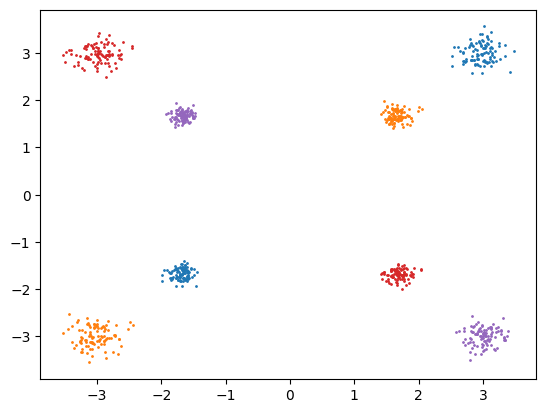

In [60]:
# General configs
nsamples = 400
jax.config.update("jax_enable_x64", True)
nn_float = jnp.float64
nn_param_init = nn.initializers.xavier_normal()
key = jax.random.PRNGKey(666)

dt = 0.01
nsteps = 400
T = nsteps * dt
ts = jnp.linspace(dt, T, nsteps)
ts_training = ts[:-1]


# Neural network construction
class MLP(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(features=100, param_dtype=nn_float, kernel_init=nn_param_init)(x)
        x = nn.gelu(x)
        x = nn.Dense(features=10, param_dtype=nn_float, kernel_init=nn_param_init)(x)
        x = nn.gelu(x)
        x = nn.Dense(features=2, param_dtype=nn_float, kernel_init=nn_param_init)(x)
        return jnp.squeeze(x)


mlp = MLP()
key, subkey = jax.random.split(key)
init_param, _, nn_eval = make_nn_with_time(mlp, dim_in=2, batch_size=10, time_scale=100, key=subkey)

# Draw training samples
key, subkey = jax.random.split(key)
keys = jax.random.split(subkey, num=4)
g1 = jnp.array([3, 3]) + 0.2 * jax.random.normal(keys[0], (int(nsamples / 4), 2))
g2 = jnp.array([-3, 3]) + 0.2 * jax.random.normal(keys[1], (int(nsamples / 4), 2))
g3 = jnp.array([-3, -3]) + 0.2 * jax.random.normal(keys[2], (int(nsamples / 4), 2))
g4 = jnp.array([3, -3]) + 0.2 * jax.random.normal(keys[3], (int(nsamples / 4), 2))
xs = jnp.concatenate([g1, g2, g3, g4], axis=0)
ys = -5 / xs

fig, ax = plt.subplots(ncols=1)
colours = ['tab:blue', 'tab:red', 'tab:orange', 'tab:purple']
for i in range(4):
    _s = int(nsamples / 4)
    ax.scatter(xs[_s * i:_s * (i + 1), 0], xs[_s * i:_s * (i + 1), 1], s=1, c=colours[i])
    ax.scatter(ys[_s * i:_s * (i + 1), 0], ys[_s * i:_s * (i + 1), 1], s=1, c=colours[i])

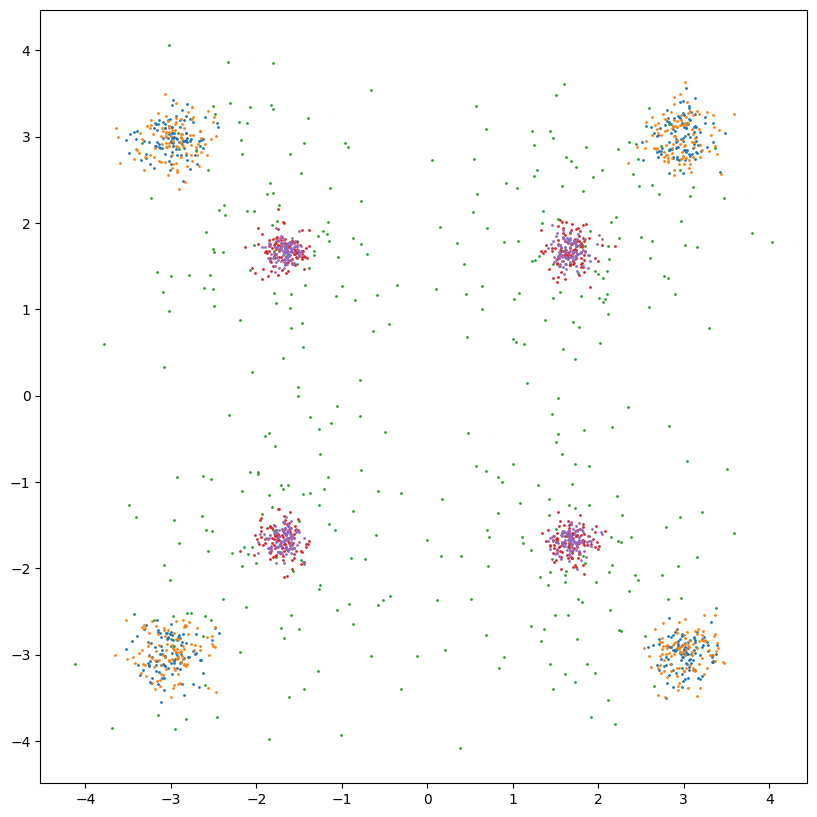

In [61]:
# Define the noising forward reference
def drift(xt, xT, t):
    """Drift of Brownian bridge SDE.
    """
    return (xT - xt) / (T - t)


def simulate_bridge_forward(x0, xT, _key):
    def scan_body(carry, elem):
        x = carry
        t, dw = elem
        x = x + drift(x, xT, t) * dt + dw
        return x, x

    _, _subkey = jax.random.split(_key)
    rnds = math.sqrt(dt) * jax.random.normal(_subkey, (nsteps - 1, 2))
    traj = jax.lax.scan(scan_body, x0, (ts[:-1], rnds))[1]
    return jnp.concatenate([traj, xT.reshape(1, -1)])


key, subkey = jax.random.split(key)
keys = jax.random.split(subkey, num=nsamples)
trajs = jax.vmap(simulate_bridge_forward, in_axes=[0, 0, 0])(xs, ys, keys)

fig, axes = plt.subplots(ncols=1, figsize=(8, 8))
axes.scatter(xs[:, 0], xs[:, 1], s=1)
axes.scatter(trajs[:, 0, 0], trajs[:, 0, 1], s=1)
axes.scatter(trajs[:, 100, 0], trajs[:, 100, 1], s=1)
axes.scatter(trajs[:, -2, 0], trajs[:, -2, 1], s=1)
axes.scatter(trajs[:, -1, 0], trajs[:, -1, 1], s=1)
plt.tight_layout(pad=0.1)

In [62]:
scales = (T - ts) * ts / (T * dt) + 0


def cond_pdf_t_0(xt, t, xT, x0):
    mt, vt = x0 + t / T * (xT - x0), (T - t) * t / T
    return jnp.sum(jax.scipy.stats.norm.logpdf(xt, mt, jnp.sqrt(vt)), axis=-1)


# @partial(jax.vmap, in_axes=[0, None, 0, 0])
# @partial(jax.vmap, in_axes=[0, 0, None, None])
def cond_score_t_0(xt, t, xT, x0):
    return jax.grad(cond_pdf_t_0)(xt, t, xT, x0)


# def loss_fn(_param, _key, overfit=True):
#     if overfit:
#         _xs = xs
#         _ys = ys
#         _keys = jax.random.split(_key, num=nsamples)
#     else:
#         _key, _subkey = jax.random.split(_key)
#         _zs = jax.random.normal(_subkey, (nsamples, 2))
#         _xs = f1(zs)
#         _ys = f2(xs)
#         _keys = jax.random.split(_subkey, num=nsamples)
#     forward_paths = jax.vmap(simulate_bridge_forward, in_axes=[0, 0, 0])(_xs, _ys, _keys)[:, :-1, :]  # (nsamples, nsteps - 1, 2)
#     errs = (jax.vmap(jax.vmap(nn_eval,
#                               in_axes=[0, 0, None]),
#                      in_axes=[0, None, None])(forward_paths, ts_training, _param) -
#             cond_score_t_0(forward_paths, ts_training, _ys, _xs)) ** 2 # (nsamples, nsteps, 2)
#     return jnp.sum(jnp.mean(errs, 0))

def compute_errs(x0, xT, _param, _key):
    def scan_body(carry, elem):
        x, err = carry
        t, dw = elem

        x = x + drift(x, xT, t) * dt + dw
        err = err + jnp.sum((nn_eval(x, t, _param) - cond_score_t_0(x, t, xT, x0)) ** 2)
        return (x, err), None

    _, _subkey = jax.random.split(_key)
    rnds = math.sqrt(dt) * jax.random.normal(_subkey, (nsteps, 2))
    return jax.lax.scan(scan_body, (x0, 0.), (ts[:-1], rnds[:-1]))[0][1]

def loss_fn(_param, _key, overfit=False):
    if overfit:
        _xs = xs
        _ys = ys
    else:
        _key, _subkey = jax.random.split(_key)
        _keys = jax.random.split(_subkey, num=4)
        g1 = jnp.array([3, 3]) + 0.2 * jax.random.normal(_keys[0], (int(nsamples / 4), 2))
        g2 = jnp.array([-3, 3]) + 0.2 * jax.random.normal(_keys[1], (int(nsamples / 4), 2))
        g3 = jnp.array([-3, -3]) + 0.2 * jax.random.normal(_keys[2], (int(nsamples / 4), 2))
        g4 = jnp.array([3, -3]) + 0.2 * jax.random.normal(_keys[3], (int(nsamples / 4), 2))
        _xs = jnp.concatenate([g1, g2, g3, g4], axis=0)
        _ys = -5 / xs
    _keys = jax.random.split(_key, num=nsamples)
    errs = jax.vmap(compute_errs, in_axes=[0, 0, None, 0])(_xs, _ys, _param, _keys)
    return jnp.mean(errs)
    
# def compute_errs(x0, xT, _param, _key):
#     def scan_body(carry, elem):
#         x, err = carry
#         t, dw = elem
# 
#         x = x + drift(x, xT, t) * dt + dw
#         err = err + jnp.trace(jax.jacfwd(nn_eval, argnums=0)(x, t, _param)) + 0.5 * jnp.sum(nn_eval(x, t, _param) ** 2)
#         return (x, err), None
# 
#     _, _subkey = jax.random.split(_key)
#     rnds = math.sqrt(dt) * jax.random.normal(_subkey, (nsteps, 2))
#     return jax.lax.scan(scan_body, (x0, 0.), (ts[:-1], rnds[:-1]))[0][1]
# 
# def loss_fn(_param, _key, overfit=False):
#     if overfit:
#         _xs = xs
#         _ys = ys
#     else:
#         _key, _subkey = jax.random.split(_key)
#         _keys = jax.random.split(subkey, num=4)
#         g1 = jnp.array([3, 3]) + 0.5 * jax.random.normal(_keys[0], (int(nsamples / 4), 2))
#         g2 = jnp.array([-3, 3]) + 0.5 * jax.random.normal(_keys[1], (int(nsamples / 4), 2))
#         g3 = jnp.array([-3, -3]) + 0.5 * jax.random.normal(_keys[2], (int(nsamples / 4), 2))
#         g4 = jnp.array([3, -3]) + 0.5 * jax.random.normal(_keys[3], (int(nsamples / 4), 2))
#         _xs = jnp.concatenate([g1, g2, g3, g4], axis=0)
#         _ys = -1 / xs
#     _keys = jax.random.split(_key, num=nsamples)
#     errs = jax.vmap(compute_errs, in_axes=[0, 0, None, 0])(_xs, _ys, _param, _keys)
#     return jnp.mean(errs)


@jax.jit
def opt_step_kernel(_param, _opt_state, _key):
    _loss, grad = jax.value_and_grad(loss_fn)(_param, _key)
    updates, _opt_state = optimiser.update(grad, _opt_state, _param)
    _param = optax.apply_updates(_param, updates)
    return _param, _opt_state, _loss


optimiser = optax.adam(learning_rate=1e-3)
opt_state = optimiser.init(init_param)
param = init_param

for i in range(50000):
    key, subkey = jax.random.split(key)
    param, opt_state, loss = opt_step_kernel(param, opt_state, subkey)
    print(f'i: {i}, loss: {loss}')

np.save('param_sdsb', param)

i: 0, loss: 2781.5675566461764
i: 1, loss: 2708.6304477099807
i: 2, loss: 2745.8841544124116
i: 3, loss: 2684.048751065987
i: 4, loss: 2616.096832518782
i: 5, loss: 2679.902000725275
i: 6, loss: 2644.3192222282332
i: 7, loss: 2571.198530242922
i: 8, loss: 2638.071606567975
i: 9, loss: 2549.1367954258594
i: 10, loss: 2579.454768283189
i: 11, loss: 2571.99761775541
i: 12, loss: 2435.837651636963
i: 13, loss: 2564.938618241231
i: 14, loss: 2515.6044121239884
i: 15, loss: 2467.249648287141
i: 16, loss: 2466.576824736288
i: 17, loss: 2462.4272268858135
i: 18, loss: 2481.439738987227
i: 19, loss: 2408.192663913783
i: 20, loss: 2470.3798135934635
i: 21, loss: 2404.56035434876
i: 22, loss: 2395.205832675192
i: 23, loss: 2393.5340627324413
i: 24, loss: 2414.3831026522926
i: 25, loss: 2326.3155721372927
i: 26, loss: 2414.6951042726664
i: 27, loss: 2363.547515843995
i: 28, loss: 2389.751161364029
i: 29, loss: 2355.2390429944517
i: 30, loss: 2318.4016749192733
i: 31, loss: 2341.7264489863023
i: 32

In [63]:
# Backward sampling
def simulate_backward(xT, _key):
    def scan_body(carry, elem):
        x = carry
        t, dw = elem

        x = x + (-drift(x, xT, T - t) + nn_eval(x, T - t, param)) * dt + dw
        return x, x

    _, _subkey = jax.random.split(_key)
    dws = jnp.sqrt(dt) * jax.random.normal(_subkey, (nsteps, 2))
    return jax.lax.scan(scan_body, xT, (ts[:-1], dws[:-1]))[1]


key, subkey = jax.random.split(key)
keys = jax.random.split(subkey, num=nsamples)
backward_traj = jax.vmap(simulate_backward, in_axes=[0, 0])(ys, keys)

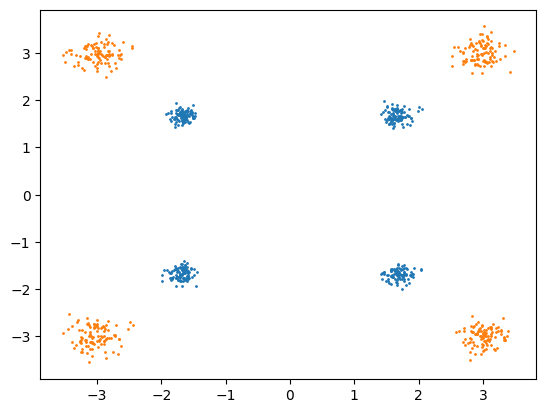

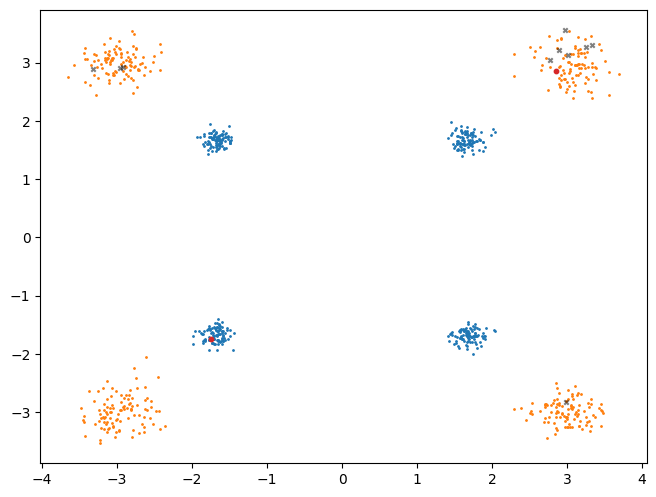

In [70]:
fig, axes = plt.subplots()
axes.scatter(ys[:, 0], ys[:, 1], s=1)
axes.scatter(xs[:, 0], xs[:, 1], s=1)
# for ax in axes:
#     ax.set_xlim([-4, 4])
#     ax.set_ylim([-1, 1])
plt.show()

fig, axes = plt.subplots()
axes.scatter(ys[:, 0], ys[:, 1], s=1)
axes.scatter(backward_traj[:, -1, 0], backward_traj[:, -1, 1], s=1)
plt.tight_layout(pad=0.1)

# Mark
idx = 2
key, subkey = jax.random.split(key)
keys = jax.random.split(subkey, num=10)
mark_y = ys[idx]
mark_x = xs[idx]
mark_xs = jax.vmap(simulate_backward, in_axes=[None, 0])(mark_y, keys)[:, -1, :]
axes.scatter(mark_y[0], mark_y[1], s=10, c='tab:red')
axes.scatter(mark_x[0], mark_x[1], s=10, c='tab:red')
axes.scatter(mark_xs[:, 0], mark_xs[:, 1], s=10, c='black', alpha=0.5, marker='x')

# for ax in axes:
#     ax.set_xlim([-4, 4])
#     ax.set_ylim([-1, 1])